In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import pandas as pd
import cv2
import os
from skimage import io, util
from skimage.transform import resize


# Ah stylé d'avoir trouvé ça !
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    average_precision_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from skimage.feature import hog
from skimage.feature import ORB
from skimage.feature import SIFT
from skimage.feature import daisy
from skimage.feature import local_binary_pattern

In [3]:
import pandas as pd

df = pd.read_csv("resultats_classification.csv", sep=",")

# Trier en fonction de la colonne 'average_precision_score'
df_sorted = df.sort_values(by="average_precision_score", ascending=False)
# Sélectionner les 10 premières lignes
df_sorted.head(10)

,model,features,accuracy,error%,rappel,precision,f1_score,average_precision_score,time_train,time_pred
0,SVC (kernel=poly),HOG,0.986851,1.314879,0.936508,0.987448,0.961303,0.935825,22.418278,5.195680
1,SVC (kernel=poly),DAISY,0.981315,1.868512,0.924603,0.966805,0.945233,0.907060,108.014973,24.313498
2,Logistic Regression (max_iter=400),HOG,0.980623,1.937716,0.920635,0.966667,0.943089,0.903788,0.687378,0.003687
3,Logistic Regression (max_iter=200),HOG,0.980623,1.937716,0.920635,0.966667,0.943089,0.903788,0.700054,0.012753
4,SVC (kernel=rbf),HOG,0.979931,2.006920,0.896825,0.986900,0.939709,0.903070,24.489752,9.351647
5,SVC,HOG,0.979931,2.006920,0.896825,0.986900,0.939709,0.903070,24.272171,9.256772
6,Logistic Regression (max_iter=25),HOG,0.979931,2.006920,0.916667,0.966527,0.940937,0.900516,0.718030,0.015188
7,Linear SVC,HOG,0.976471,2.352941,0.916667,0.946721,0.931452,0.882361,4.258291,0.003648
8,SVC,DAISY,0.973702,2.629758,0.876984,0.969298,0.920833,0.871512,179.627072,70.593682
9,SVC (kernel=rbf),DAISY,0.973702,2.629758,0.876984,0.969298,0.920833,0.871512,184.823917,66.016438


In [4]:
# Chargement des données
pos_patch_fs = [
    f
    for f in os.listdir(os.path.join("local_data", "4_normalized_patches", "pos"))
    if f.endswith(".jpg")
]
neg_patch_fs = [
    f
    for f in os.listdir(os.path.join("local_data", "4_normalized_patches", "neg"))
    if f.endswith(".jpg")
]

pos_patchs = []
neg_patchs = []

for f in pos_patch_fs:
    try:
        patch = plt.imread(os.path.join("local_data", "4_normalized_patches", "pos", f))
        pos_patchs.append(
            patch[:, :, 0]
        )  # le channel grayscale est dupliqué sur les 3 chanaux RGB (on en isole 1)

    except FileNotFoundError:
        continue

for f in neg_patch_fs:
    try:
        patch = plt.imread(os.path.join("local_data", "4_normalized_patches", "neg", f))
        neg_patchs.append(
            patch[:, :, 0]
        )  # le channel grayscale est dupliqué sur les 3 chanaux RGB (on en isole 1)

    except FileNotFoundError:
        continue

print(len(pos_patchs))
print(len(neg_patchs))

print(pos_patchs[0].shape)  # on est bien en grayscale

nb_patchs_tot = len(pos_patchs) + len(neg_patchs)

train_part = 80 / 100
train_size = int(nb_patchs_tot * train_part)

# Mélange des indices, pour que les données soient mélangées "en même temps" que les classes vérités
indices = np.arange(nb_patchs_tot)
np.random.shuffle(indices)

# Fabrication des classes : 1 : positif, 0 : négatif
y = []
for _ in range(len(pos_patchs)):
    y.append(1)

for _ in range(len(neg_patchs)):
    y.append(0)
y_shuffled = np.array(y)[indices]
y_train = y_shuffled[0:train_size]
y_test = y_shuffled[train_size:]

print(len(y_shuffled))
print(len(y_train))
print(len(y_test))

patchs = np.array(pos_patchs + neg_patchs)
print(patchs.shape)


def get_X_train_and_test_for_extractor(extractor):

    X = extractor(patchs)
    # print(X.shape)

    X_shuffled = X[indices]
    X_train = X_shuffled[0:train_size]
    X_test = X_shuffled[train_size:]

    return X_train, X_test


def HOG_extractor(patchs):
    first_features = hog(patchs[0])  # valeurs par défaut
    features = np.zeros(
        shape=(len(patchs), first_features.shape[0]), dtype=first_features.dtype
    )
    for i, patch in enumerate(patchs):
        features[i] = hog(patch)

    return features


X_train, X_test = get_X_train_and_test_for_extractor(HOG_extractor)

1204
6020
(128, 72)
7224
5779
1445
(7224, 128, 72)


In [ ]:
# Test du SVM polynomial
from sklearn import svm
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    average_precision_score,
)
import pandas as pd


# Degrés du polynôme
degree_list = [2, 3, 4]

# Controle de la compléxité du modèle
C_list = [0.1, 5, 100]

# Paramètres coef0
# Il s'agit d'un paramètre de la fonction noyau polynomial qui contrôle l'importance du terme constant.
coef0_list = [0, 5, 10]

gamma_list = ["scale", "auto"]

df_resultats = pd.DataFrame(
    columns=[
        "degree",
        "C",
        "coef0",
        "accuracy",
        "recall",
        "precision",
        "f1_score",
        "average_precision_score",
    ]
)

In [8]:
# Création d'un dictionnaire pour stocker les modèles entrainés
models = {}

for degree in degree_list:
    for C in C_list:
        for coef0 in coef0_list:
            for gamma in gamma_list:
                print(
                    f"Entraînement du modèle SVM polynomial avec degree={degree}, C={C}, coef0={coef0}, gamma={gamma}"
                )
                # Création du modèle SVM polynomial
                model = svm.SVC(
                    kernel="poly", degree=degree, C=C, coef0=coef0, gamma=gamma
                )

                # Entraînement du modèle
                model.fit(X_train, y_train)

                # Stockage du modèle dans le dictionnaire
                models[(degree, C, coef0, gamma)] = model

                # Prédictions
                y_pred = model.predict(X_test)

                # Calcul des métriques
                accuracy = accuracy_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred, average="macro")
                precision = precision_score(y_test, y_pred, average="macro")
                f1 = f1_score(y_test, y_pred, average="macro")
                avg_precision = average_precision_score(y_test, y_pred)
                # Ajout des résultats au DataFrame
                df_resultats = pd.concat(
                    [
                        df_resultats,
                        pd.DataFrame(
                            [
                                {
                                    "degree": degree,
                                    "C": C,
                                    "coef0": coef0,
                                    "accuracy": accuracy,
                                    "recall": recall,
                                    "precision": precision,
                                    "f1_score": f1,
                                    "average_precision_score": avg_precision,
                                }
                            ]
                        ),
                    ],
                    ignore_index=True,
                )

Entraînement du modèle SVM polynomial avec degree=2, C=0.1, coef0=0, gamma=scale


C:\Users\engel\AppData\Local\Temp\ipykernel_128968\3757813861.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultats = pd.concat(


Entraînement du modèle SVM polynomial avec degree=2, C=0.1, coef0=5, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=0.1, coef0=10, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=5, coef0=0, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=5, coef0=5, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=5, coef0=10, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=100, coef0=0, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=100, coef0=5, gamma=scale
Entraînement du modèle SVM polynomial avec degree=2, C=100, coef0=10, gamma=scale
Entraînement du modèle SVM polynomial avec degree=3, C=0.1, coef0=0, gamma=scale
Entraînement du modèle SVM polynomial avec degree=3, C=0.1, coef0=5, gamma=scale
Entraînement du modèle SVM polynomial avec degree=3, C=0.1, coef0=10, gamma=scale
Entraînement du modèle SVM polynomial avec degree=3, C=5, coef0=0, gamma=scale
Entraînement du modèle SVM polyn

In [9]:
# Trier par average_precision_score
df_resultats = df_resultats.sort_values(by="average_precision_score", ascending=False)
df_resultats.to_csv("optimisation_SVM.csv", index=False)

In [10]:
df_resultats.head(10)

,degree,C,coef0,accuracy,recall,precision,f1_score,average_precision_score
12,3,5.0,0,0.993772,0.985832,0.990983,0.988386,0.965529
15,3,100.0,0,0.993772,0.985832,0.990983,0.988386,0.965529
3,2,5.0,0,0.993080,0.983677,0.990545,0.987073,0.961911
6,2,100.0,0,0.993080,0.983677,0.990545,0.987073,0.961911
24,4,100.0,0,0.991696,0.977624,0.991441,0.984377,0.955273
21,4,5.0,0,0.991696,0.977624,0.991441,0.984377,0.955273
18,4,0.1,0,0.990311,0.973314,0.990590,0.981708,0.948037
25,4,100.0,5,0.990311,0.978542,0.985337,0.981902,0.946356
19,4,0.1,5,0.990311,0.978542,0.985337,0.981902,0.946356
22,4,5.0,5,0.990311,0.978542,0.985337,0.981902,0.946356


<Axes: xlabel='degree_C_coef0'>

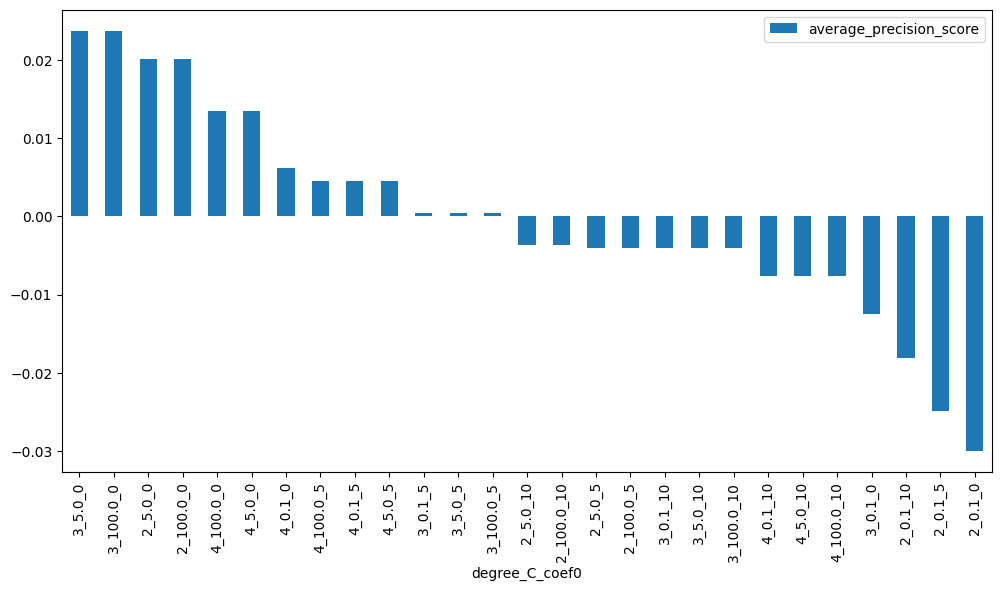

In [13]:
# On va calculer la moyenne de average_precision_score
mean_avg_precision = df_resultats["average_precision_score"].mean()
df_resultats_centered = df_resultats.copy()
df_resultats_centered["average_precision_score"] -= mean_avg_precision
# Fusionner les colonnes degree, C et coef0 pour l'affichage
df_resultats_centered["degree"] = df_resultats_centered["degree"].astype(str)
df_resultats_centered["C"] = df_resultats_centered["C"].astype(str)
df_resultats_centered["coef0"] = df_resultats_centered["coef0"].astype(str)
df_resultats_centered["degree_C_coef0"] = (
    df_resultats_centered["degree"]
    + "_"
    + df_resultats_centered["C"]
    + "_"
    + df_resultats_centered["coef0"]
)
# Affichage des résultats en histogramme
plt.figure(figsize=(12, 6))
df_resultats_centered.plot(
    x="degree_C_coef0",
    y="average_precision_score",
    kind="bar",
    ax=plt.gca(),
)

Meilleur modèle SVM polynomial :  (3, np.float64(5.0), 0, 'scale')
AUC ROC: 1.00
AUC PR: 0.99


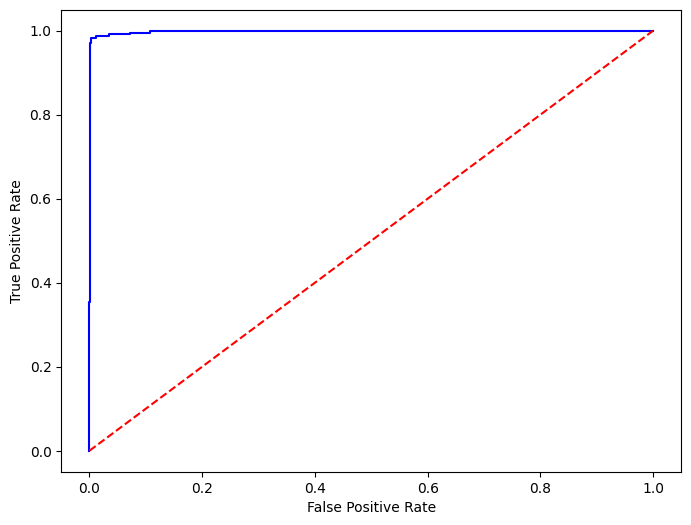

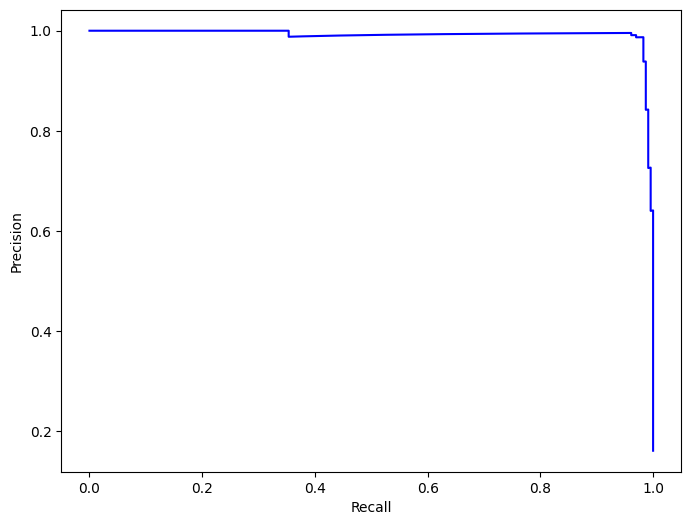

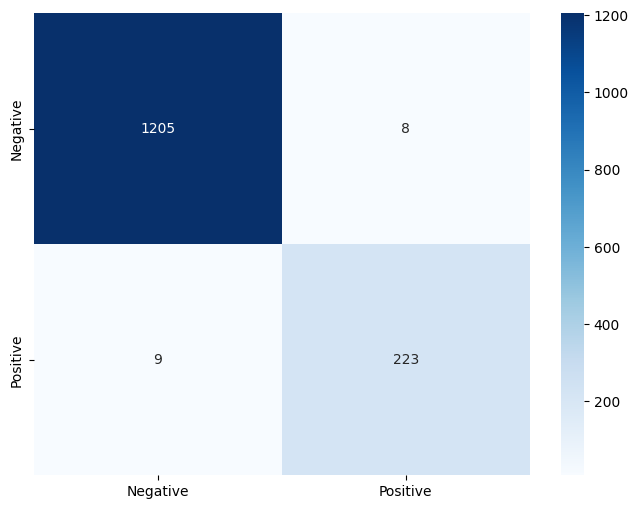

In [28]:
best_average_precision_score = df_resultats["average_precision_score"].max()

best_params = df_resultats.loc[
    df_resultats["average_precision_score"] == best_average_precision_score
].iloc[0]

best_params_tuple = (
    best_params["degree"],
    best_params["C"],
    best_params["coef0"],
    "scale",
)

best_model = models[best_params_tuple]

print("Meilleur modèle SVM polynomial : ", best_params_tuple)

# Courbe ROC
# Ici généré par gpt
from sklearn.metrics import roc_curve, auc

# Calcul des scores de décision
y_scores = best_model.decision_function(X_test)

# Calcul des courbes ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


# Courbe Recall-Precision
from sklearn.metrics import precision_recall_curve

# Calcul des scores de décision
# Calcul des courbes de précision et de rappel
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# Calcul de l'aire sous la courbe de précision et de rappel
pr_auc = average_precision_score(y_test, y_scores)
# Affichage de la courbe de précision et de rappel
plt.figure(figsize=(8, 6))
plt.plot(
    recall,
    precision,
    color="blue",
    label="Precision-Recall curve (area = {:.2f})".format(pr_auc),
)
plt.xlabel("Recall")
plt.ylabel("Precision")


# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)

# print les AUC
print("AUC ROC: {:.2f}".format(roc_auc))
print("AUC PR: {:.2f}".format(pr_auc))

In [26]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
